Total de logos detectados: 12
Tamaño del template usado: 100x100


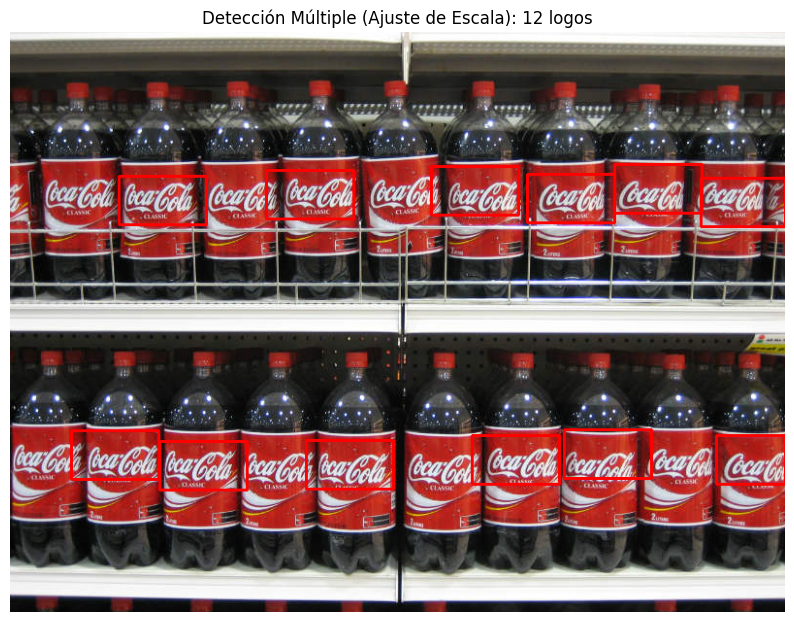

In [4]:
# PUNTO 2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive

# --- 1. CONFIGURACIÓN ---

# drive.mount('/content/gdrive', force_remount=True)

# Carga la imagen de template y multi-imagen
template = cv.imread('template/pattern_cropped_inverted2.png', cv.IMREAD_GRAYSCALE)
multi_img_path = 'images/coca_multi.png'
multi_img_color = cv.imread(multi_img_path)

if multi_img_color is None or template is None:
    raise FileNotFoundError("Error: No se pudo cargar el template o la imagen multi.")

multi_img_gray = cv.cvtColor(multi_img_color, cv.COLOR_BGR2GRAY)

NEW_TEMPLATE_SIZE = (100, 100) # (ancho, alto)
template = cv.resize(template, NEW_TEMPLATE_SIZE)


w, h = template.shape[::-1] # Actualiza el ancho y alto del template re-escalado

# --- 2. DETECCIÓN CON TEMPLATE MATCHING (MÉTODO FLEXIBLE) ---

METHOD = cv.TM_CCORR_NORMED
res = cv.matchTemplate(multi_img_gray, template, METHOD)
THRESHOLD = 0.8484

loc = np.where(res >= THRESHOLD)

# --- 3. PREPARACIÓN DE CAJAS PARA NMS ---

rectangles = []
# [x_min, y_min, ancho, alto]
for pt in zip(*loc[::-1]):
    rectangles.append([int(pt[0]), int(pt[1]), w, h])

rectangles = np.array(rectangles)

# --- 4. NON-MAXIMUM SUPPRESSION (NMS AGRESIVA) ---

NMS_OVERLAP_THRESHOLD = 0.05 # Mantenemos el NMS agresivo

pick = cv.dnn.NMSBoxes(
    rectangles.tolist(),
    [1.0] * len(rectangles),
    score_threshold=THRESHOLD,
    nms_threshold=NMS_OVERLAP_THRESHOLD
)

# --- 5. DIBUJAR LOS RESULTADOS ---

detections_count = 0
for i in pick:
    idx = i if np.isscalar(i) else i[0]
    x, y, w_box, h_box = rectangles[idx]

    # --- FILTRO DE COLOR ROJO (para eliminar falsos positivos) ---
    roi = multi_img_color[y:y+h_box, x:x+w_box]
    roi_hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)

    # Rango típico del rojo en Coca-Cola (dos zonas en HSV)
    mask1 = cv.inRange(roi_hsv, (0, 70, 50), (10, 255, 255))
    mask2 = cv.inRange(roi_hsv, (170, 70, 50), (180, 255, 255))
    mask_red = cv.bitwise_or(mask1, mask2)

    # Calcula porcentaje de píxeles rojos
    red_ratio = cv.countNonZero(mask_red) / (roi.shape[0] * roi.shape[1])

    # Si tiene poco rojo, probablemente sea un falso positivo
    if red_ratio < 0.12:
        continue

    # Corrige el centrado del rectángulo
    x_offset = int((w_box - w_box * 0.3)/2)
    y_offset = int((h_box - h_box * 0.5)/2)

    x_new = x + x_offset if x + x_offset > 0 else x
    y_new = y + y_offset if y + y_offset > 0 else y
    w_new = int(w_box * 0.9)
    h_new = int(h_box * 0.5)

    # Ajuste final para que no se pase de la imagen
    if x_new + w_new > multi_img_color.shape[1]:
        w_new = multi_img_color.shape[1] - x_new
    if y_new + h_new > multi_img_color.shape[0]:
        h_new = multi_img_color.shape[0] - y_new

    cv.rectangle(multi_img_color,
                (x_new, y_new),
                (x_new + w_new, y_new + h_new),
                (0, 0, 255), 2)

    detections_count += 1

print(f"Total de logos detectados: {detections_count}")
print(f"Tamaño del template usado: {NEW_TEMPLATE_SIZE[0]}x{NEW_TEMPLATE_SIZE[1]}")

plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(multi_img_color, cv.COLOR_BGR2RGB))
plt.title(f"Detección Múltiple (Ajuste de Escala): {detections_count} logos")
plt.axis('off')
plt.show()